# Mask R-CNN
- object detection
- 코드 구현 및 학습

#### 1. 라이브러리 로드

In [2]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold

- 데이터 로드

In [3]:
data_file_path = 'rsna-pneumonia'
# to save the model to the current directory
file_path = 'working'
# Temporaary files stores just for this session
temp_file_path = 'temp'

#### 2. clone the repository

In [10]:
!git clone https://www.github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


- Install the dependencies

In [ ]:
!pip install tensorflow-gpu==1.13.1
!pip install tensorflow==1.13.1
!pip install keras==2.0.8

- root directory

In [4]:
sys.path.append(os.path.join(file_path, 'Mask_RCNN'))

- tensorflow install

In [5]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
import mrcnn

c:\Users\82106\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\82106\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\82106\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\82106\anaconda3\envs\tensorflow\lib\site-packages

- data directory

In [6]:
train_dicom_dir = os.path.join(data_file_path, 'stage_2_train_images')
test_dicom_dir = os.path.join(data_file_path, 'stage_2_test_images')

- download COCO weights

In [6]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
ls: cannot access 'mask_rcnn_coco.h5': No such file or directory


In [7]:
Weights_file_path = "mask_rcnn_coco.h5"

#### 5. image 시각화 준비

In [8]:
def get_dicom_fps(dicom_dir):
    # To get a list of dicom images
    dicom_img = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_img))

def parse_dataset(dicom_dir, annotations): 
    # returns a list of all images
    image_fps = get_dicom_fps(dicom_dir)
    # annotates the list of images obtained
    image_annotations = {fp: [] for fp in image_fps}
    
    for index, row in annotations.iterrows(): 
        
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
        
    return image_fps, image_annotations 

In [9]:
class PneumoniaConfig(Config):
    """Configuration for training Lung Opacity location detection on the RSNA pneumonia dataset. Created a
    sub-class that inherits from config class and override properties that need to be changed.
    """
    # Name the configurations. 
    NAME = 'Lung_Opacity'  # Override in sub-classes

    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1
    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    # Train on 2 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    IMAGES_PER_GPU = 8
    
    

    # Number of training steps per epoch
    # This doesn't need to match the size of the training set. Tensorboard
    # updates are saved at the end of each epoch, so setting this to a
    # smaller number means getting more frequent TensorBoard updates.
    # Validation stats are also calculated at each epoch end and they
    # might take a while, so don't set this too small to avoid spending
    # a lot of time on validation stats.
    STEPS_PER_EPOCH = 32
    VALIDATION_STEPS = 8

    
    # Backbone network architecture
    # Supported values are: resnet50, resnet101.
    # You can also provide a callable that should have the signature
    # of model.resnet_graph. If you do so, you need to supply a callable
    # to COMPUTE_BACKBONE_SHAPE as well
    # Here, we leave it as resnet 101
    BACKBONE = 'resnet50'
    
    # Length of square anchor side in pixels
#     RPN_ANCHOR_SCALES = (32, 64, 128, 256)
#     BACKBONE_STRIDES = [4, 8, 16, 32]
    

    # Number of classification classes (including background)
    NUM_CLASSES = 2  # background and 1 pneumonia class
    
    # Input image resizing
    # Generally, use the "square" resizing mode for training and predicting
    # and it should work well in most cases. In this mode, images are scaled
    # up such that the small side is = IMAGE_MIN_DIM, but ensuring that the
    # scaling doesn't make the long side > IMAGE_MAX_DIM. Then the image is
    # padded with zeros to make it a square so multiple images can be put
    # in one batch.
    # Available resizing modes:
    # none:   No resizing or padding. Return the image unchanged.
    # square: Resize and pad with zeros to get a square image
    #         of size [max_dim, max_dim].
    # pad64:  Pads width and height with zeros to make them multiples of 64.
    #         If IMAGE_MIN_DIM or IMAGE_MIN_SCALE are not None, then it scales
    #         up before padding. IMAGE_MAX_DIM is ignored in this mode.
    #         The multiple of 64 is needed to ensure smooth scaling of feature
    #         maps up and down the 6 levels of the FPN pyramid (2**6=64).
    # crop:   Picks random crops from the image. First, scales the image based
    #         on IMAGE_MIN_DIM and IMAGE_MIN_SCALE, then picks a random crop of
    #         size IMAGE_MIN_DIM x IMAGE_MIN_DIM. Can be used in training only.
    #         IMAGE_MAX_DIM is not used in this mode.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 32

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 3
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 3
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.8

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.1
        
config = PneumoniaConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES   

In [10]:
class PneumoniaDataset(utils.Dataset):
    """
    Dataset class for training automated loation detection for lung opacities on the RSNA pneumonia dataset. For overriding the Base dataset class in Matterport's Mask R-CNN.
    
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        # For parent class
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            
            # Adding annotations
            annotations = image_annotations[fp]
            
            # Add image function (self, source, image_id, path, anntations)
            self.add_image('pneumonia', 
                           image_id=i, 
                           path=fp, 
                           annotations=annotations, 
                           orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.
        Override for pneumonia dataset, and pass to this function
        if you encounter images not in your dataset.
        """
        info = self.image_info[image_id]
        return info['path']

    
    def load_image(self, image_id):
        """
        Load the specified image and return a [H,W,3] Numpy array.
        """
        info = self.image_info[image_id]
        
        fp = info['path']
        
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
 

        return image

    
    def load_mask(self, image_id):
        """
        Load instance masks for the given image.
        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """


        info = self.image_info[image_id]
        
        annotations = info['annotations']
        
        count = len(annotations)
        
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
            
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            
            for i, a in enumerate(annotations):
                
                if a['Target'] == 1:
                    
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
                    
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [11]:
annotations = pd.read_csv(os.path.join(data_file_path, 'stage_2_train_labels.csv'))
annotations

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [12]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, annotations=annotations)

In [13]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [14]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.14347.1517874378.926824
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.14347.1517874378.926824
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [15]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

In [16]:
image_fps_list = list(image_fps)

# Seeding to get same results in case of shuffling the data
random.seed(42)

random.shuffle(image_fps_list)

# Validation size
#val_size = 8100
image_fps_validate1 = image_fps_list[:4000]
image_fps_training = image_fps_list[4000:13000]

random.shuffle(image_fps_list)

# Validation size
# test_size = 4050
image_fps_validate = image_fps_validate1[:2000]
image_fps_test = image_fps_validate1[2000:11000]

print(len(image_fps_training), len(image_fps_validate))
print(image_fps_validate[:5])
print(image_fps_test[:5])

9000 2000
['rsna-pneumonia\\stage_2_train_images\\9b1db34a-a649-485c-b615-f464c145b88c.dcm', 'rsna-pneumonia\\stage_2_train_images\\f75f713d-fbf5-4844-a112-f8d0e6683ff9.dcm', 'rsna-pneumonia\\stage_2_train_images\\c80376a0-e71c-4519-844d-0d12e83b25ae.dcm', 'rsna-pneumonia\\stage_2_train_images\\12d2566d-fd1e-476c-8be4-68d15657d7d0.dcm', 'rsna-pneumonia\\stage_2_train_images\\90fe31b9-28ea-4e44-8fad-43e5997d2885.dcm']
['rsna-pneumonia\\stage_2_train_images\\490fba93-3449-45f7-abe4-49a948b00fd2.dcm', 'rsna-pneumonia\\stage_2_train_images\\f50f3c2d-e52b-40d2-9acc-277cd996e673.dcm', 'rsna-pneumonia\\stage_2_train_images\\dfddd047-8c03-4034-af8c-b4b0834cff3f.dcm', 'rsna-pneumonia\\stage_2_train_images\\ce011009-c426-4b6a-be7d-f6391493c910.dcm', 'rsna-pneumonia\\stage_2_train_images\\e9194aa8-56de-4b89-8f4e-91e58973ef50.dcm']


In [17]:
# prepare the training dataset
dataset_train = PneumoniaDataset(image_fps_training, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [18]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_training)
image_annotations[test_fp]

[patientId    3c0f1edd-10c2-46da-a01c-a151aa88f2df
 x                                           184.0
 y                                           406.0
 width                                       256.0
 height                                      434.0
 Target                                          1
 Name: 3999, dtype: object,
 patientId    3c0f1edd-10c2-46da-a01c-a151aa88f2df
 x                                           626.0
 y                                           428.0
 width                                       245.0
 height                                      290.0
 Target                                          1
 Name: 4000, dtype: object]

In [19]:
# prepare the validation dataset
dataset_val = PneumoniaDataset(image_fps_validate, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

c:\Users\82106\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:96: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(1024, 1024, 3)
rsna-pneumonia\stage_2_train_images\ec93d206-ec61-4e16-afc4-898f754916fa.dcm
[1 1]


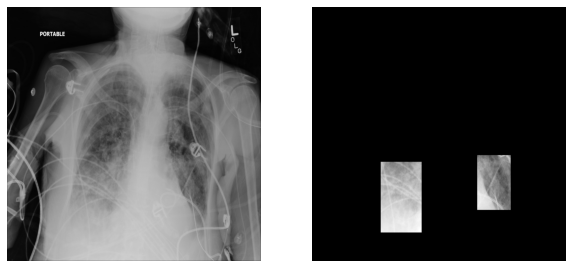

In [20]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)

plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])

for i in range(mask.shape[2]):
    masked += image[:,:,0] * mask[:,:,i]
    
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

c:\Users\82106\anaconda3\envs\tensorflow\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


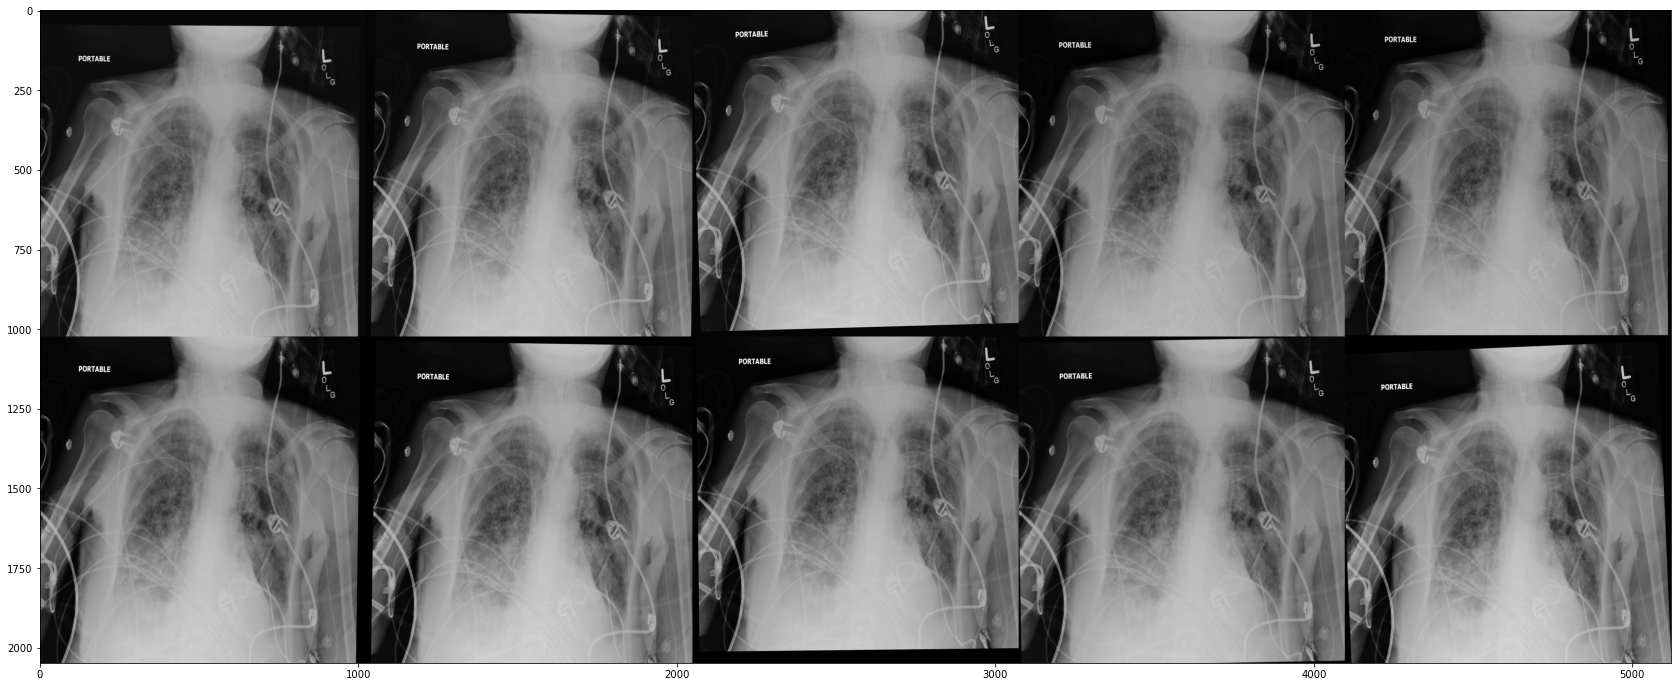

In [21]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [22]:
DATA_DIR = 'rsna-pneumonia'
ROOT_DIR = 'working'
train_dir=os.path.join(DATA_DIR, 'stage_2_train_images')
test_dir=os.path.join(DATA_DIR, 'stage_2_test_images')

In [23]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': train_dir+ '/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [24]:
df = pd.read_csv(os.path.join(data_file_path,'stage_2_train_labels.csv'))
df.head()
parsed = parse_data(df)

In [25]:
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

In [26]:
img_list=list(parsed.keys())
print(len(img_list))

26684


In [27]:
class pneumoniaConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "pneumonia"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 8
    GPU_COUNT = 1
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = 200

    DETECTION_MIN_CONFIDENCE = 0.78

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"


    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)


    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 50

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 4

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 3
    DETECTION_NMS_THRESHOLD = 0.01
class InferenceConfig(pneumoniaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
config=pneumoniaConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

In [28]:
class pneumoniaDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_list, parsed, h,w):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for pid in image_list:
            boxes = parsed[pid]['boxes']
            self.add_image('pneumonia', image_id=pid, path=parsed[pid]['dicom'],boxes=boxes, 
                            h=h, w=w)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        d = pydicom.read_file(fp)
        im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
        im = np.stack([im] * 3, axis=2)
        return im

    def load_mask(self, image_id):
#          Generate instance masks for an image.
#        Returns:
#         masks: A bool array of shape [height, width, instance count] with
#             one mask per instance.
#         class_ids: a 1D array of class IDs of the instance masks.
#         
        info = self.image_info[image_id]
        boxes = info['boxes']
        count = len(boxes)
        if count == 0:
            mask = np.zeros((info['h'], info['w'], 1), dtype=np.bool)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['h'], info['w'], count), dtype=np.bool)
            class_ids = np.ones((count,), dtype=np.int32)
            for i, box in enumerate(boxes):
                box = [int(b) for b in box]
                y1, x1, height, width = box
                y2 = y1 + height
                x2 = x1 + width
                mask[y1:y2, x1:x2 ,i]=1
        return mask, class_ids

In [29]:
random.seed(42)
random.shuffle(img_list)
val = 1500
im_val = img_list[:val]
im_train = img_list[val:]

In [30]:
# Training dataset.
dataset_train = pneumoniaDataset(im_train, parsed, 1024,1024)
dataset_train.prepare()

# Validation dataset
dataset_val = pneumoniaDataset(im_val,parsed, 1024,1024)
dataset_val.prepare()

In [31]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

In [32]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [33]:
LEARNING_RATE = 0.006

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [34]:
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=3,
            layers='all',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0012000000000000001

Checkpoint Path: working\pneumonia20220517T1825\mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_br

KeyboardInterrupt: 

In [35]:
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps)
image_fps_list = list(image_fps[:1000]) 
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

900 100


In [37]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [38]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [39]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    8e2b2c4e-18b8-4a78-8817-b1e8a1a5f32e
 x                                           507.0
 y                                           173.0
 width                                       266.0
 height                                      530.0
 Target                                          1
 Name: 14361, dtype: object,
 patientId    8e2b2c4e-18b8-4a78-8817-b1e8a1a5f32e
 x                                           152.0
 y                                           162.0
 width                                       264.0
 height                                      528.0
 Target                                          1
 Name: 14362, dtype: object]

In [40]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
rsna-pneumonia\stage_2_train_images\b2651591-53ae-450f-ae37-2220cf6108e7.dcm
[1 1]


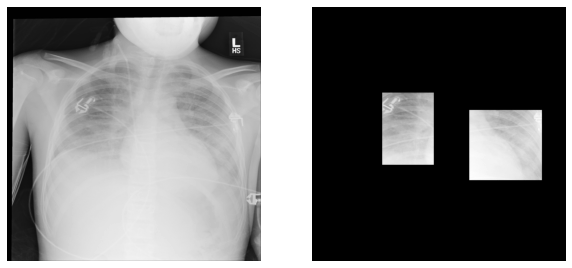

In [41]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [40]:
# These parameters have been changed to reduce run-time per epoch at the expense 
# of training performance

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    NAME = 'pneumonia'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16 # on aws, use 16
    BACKBONE = 'resnet50'
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    RPN_ANCHOR_SCALES = (32, 64)
    TRAIN_ROIS_PER_IMAGE = 16
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    POST_NMS_ROIS_TRAINING = 200
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
     
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES      

In [39]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, source_name, dataset, orig_height, orig_width):
        super().__init__(self)
        
        # add classes 
        for k, v in dataset.classes_dict.items():
            if v['class_id'] is not 0: 
                self.add_class(source_name, v['class_id'], v['class_text'])

        # add images 
        img_ids = dataset.get_image_ids()
        imgs_anns_dict = dataset.imgs_anns_dict
        
        #########################################################
        # WARNING: Using only the first 1000 images to reduce 
        #          run-time for demonstration only 
        # To run all images, do: for i, fp in enumerate(img_ids):
        #########################################################
        for i, fp in enumerate(img_ids[:1000]):
            annotations = imgs_anns_dict[fp]
            self.add_image(source_name, image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(
            fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            assert(dataset.label_id_to_class_id(a['labelId']) == 0)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['data'] is not None:
                    x = int(a['data']['x'])
                    y = int(a['data']['y'])
                    w = int(a['data']['width'])
                    h = int(a['data']['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = dataset.label_id_to_class_id(a['labelId'])
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import pydicom
import os
from os import listdir
from os.path import isfile, join
# print(os.listdir("../input"))

In [42]:
# Images Example
train_images_dir = 'rsna-pneumonia/stage_2_train_images/'
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
test_images_dir = 'rsna-pneumonia/stage_2_test_images/'
test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]
print('5 Training images', train_images[:5]) # Print the first 5

5 Training images ['0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', '000924cf-0f8d-42bd-9158-1af53881a557.dcm', '000db696-cf54-4385-b10b-6b16fbb3f985.dcm', '000fe35a-2649-43d4-b027-e67796d412e0.dcm', '001031d9-f904-4a23-b3e5-2c088acd19c6.dcm']


In [43]:
# Training dataset
source_name = 'pneumonia'
dataset_train = DetectorDataset(source_name, train_images, 1024, 1024)
dataset_train.prepare()

# Validation dataset
dataset_val = DetectorDataset(source_name, test_images, 1024, 1024)
dataset_val.prepare()

AttributeError: 'list' object has no attribute 'classes_dict'